In [ ]:
import sys

sys.path.append('../../')

import os
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from matplotlib import pyplot as plt
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import keras.backend as K
from Pipeline.Multi_task.uncertainty_weighting import CustomMultiLossLayer
from keras.layers import Dense, Conv1D, MaxPool1D, Lambda
from keras import Input, Model
from keras import Sequential

from Pipeline.preprocess import BandpassFilter
from Pipeline.tf_dataset_builder import RawDatasetBuilder
from Pipeline.evaluation import false_alarm_rate, miss_detection_rate
from Pipeline.tf_lite_utils import predict_tflite_mtl, convert_tf_lite_mtl
from Pipeline.evaluation import plot_confusion_matrix

In [2]:
# Set seed for experiment reproducibility
seed = 1
tf.random.set_seed(seed)

In [3]:
# Define paths to model files
MODELS_DIR = '../../Models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'uw_model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'uw_model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'uw_model.tflite'

In [4]:
class_dict = {
    'Background': 0,
    'Big mandibles': 1,
    'Small mandibles': 2,
}

In [5]:
# Set hyperparameters
batch_size = 64
learning_rate = 0.0005
epochs = 100
patience = 5
gamma = 0.5

In [6]:
# Load the data: raw extraction
raw_builder = RawDatasetBuilder(
    #dataset_dir="../../Dataset/Generated dataset/Deployment/unstandardized/50ms/**/*.wav",
    dataset_dir="../../Dataset/Final dataset/Generation/Generated dataset/**/*.wav",
    class_dict=class_dict,
    seed=seed,
)
train_dataset, val_dataset, test_dataset = raw_builder.build(val_split=0.2, test_split=0.2)

In [7]:
bandpass = BandpassFilter(200, 20000, 44100, order=2)

x_train = [bandpass.filter(feature) for feature in train_dataset[0]]
x_train = np.array(x_train)
y_c_train = np.array(train_dataset[1])
y_d_train = np.array(train_dataset[1], copy=True)
y_d_train[y_d_train != 0] = 1

x_val = [bandpass.filter(feature) for feature in val_dataset[0]]
x_val = np.array(x_val)
y_c_val = np.array(val_dataset[1])
y_d_val = np.array(val_dataset[1], copy=True)
y_d_val[y_d_val != 0] = 1

x_test = [bandpass.filter(feature) for feature in test_dataset[0]]
x_test = np.array(x_test)
y_c_test = np.array(test_dataset[1])
y_d_test = np.array(test_dataset[1], copy=True)
y_d_test[y_d_test != 0] = 1

In [8]:
input_shape = np.expand_dims(x_train[0], axis=1).shape
input_shape

(2205, 1)

In [9]:
backbone = Sequential([
    Conv1D(filters=8, kernel_size=80, padding="same", activation='relu'),
    MaxPool1D(pool_size=4, strides=2),
    Conv1D(filters=8, kernel_size=3, padding="same", activation='relu'),
    MaxPool1D(pool_size=4, strides=2),
    Conv1D(filters=8, kernel_size=3, padding="same", activation='relu'),
    MaxPool1D(pool_size=4, strides=2),
    Lambda(lambda x: K.mean(x, axis=1)),
    Dense(units=32, activation='relu'),
])

detection_head = Sequential([
    Dense(32),
    Dense(1, activation='sigmoid'),
])
detection_head._name = 'detection'

classification_head = Sequential([
    Dense(32),
    Dense(len(class_dict), activation='softmax'),
])
classification_head._name = 'classification'

In [10]:
def get_prediction_model():
    inp = Input(shape=input_shape, name='input_layer')
    latent = backbone(inp)
    y1_pred = detection_head(latent)
    y2_pred = classification_head(latent)
    return Model(inp, [y1_pred, y2_pred])

def get_trainable_model(prediction_model):
    inp = Input(shape=input_shape, name='input_layer')
    y1_pred, y2_pred = prediction_model(inp)
    y1_true = Input(shape=(1,), name='y_true_detection')
    y2_true = Input(shape=(1,), name='y_true_classification')
    out = CustomMultiLossLayer(nb_outputs=2)([y1_true, y2_true, y1_pred, y2_pred])
    return Model([inp, y1_true, y2_true], out)

prediction_model = get_prediction_model()
trainable_model = get_trainable_model(prediction_model)
trainable_model.compile(optimizer='adam', loss=None)

assert len(trainable_model.layers[-1].trainable_weights) == 2  # two log_vars, one for each output
assert len(trainable_model.losses) == 1

In [11]:
trainable_model.summary(expand_nested=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 2205, 1)]    0           []                               
                                                                                                  
 y_true_detection (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 y_true_classification (InputLa  [(None, 1)]         0           []                               
 yer)                                                                                             
                                                                                                  
 model (Functional)             [(None, 1),          3580        ['input_layer[0][0]']      

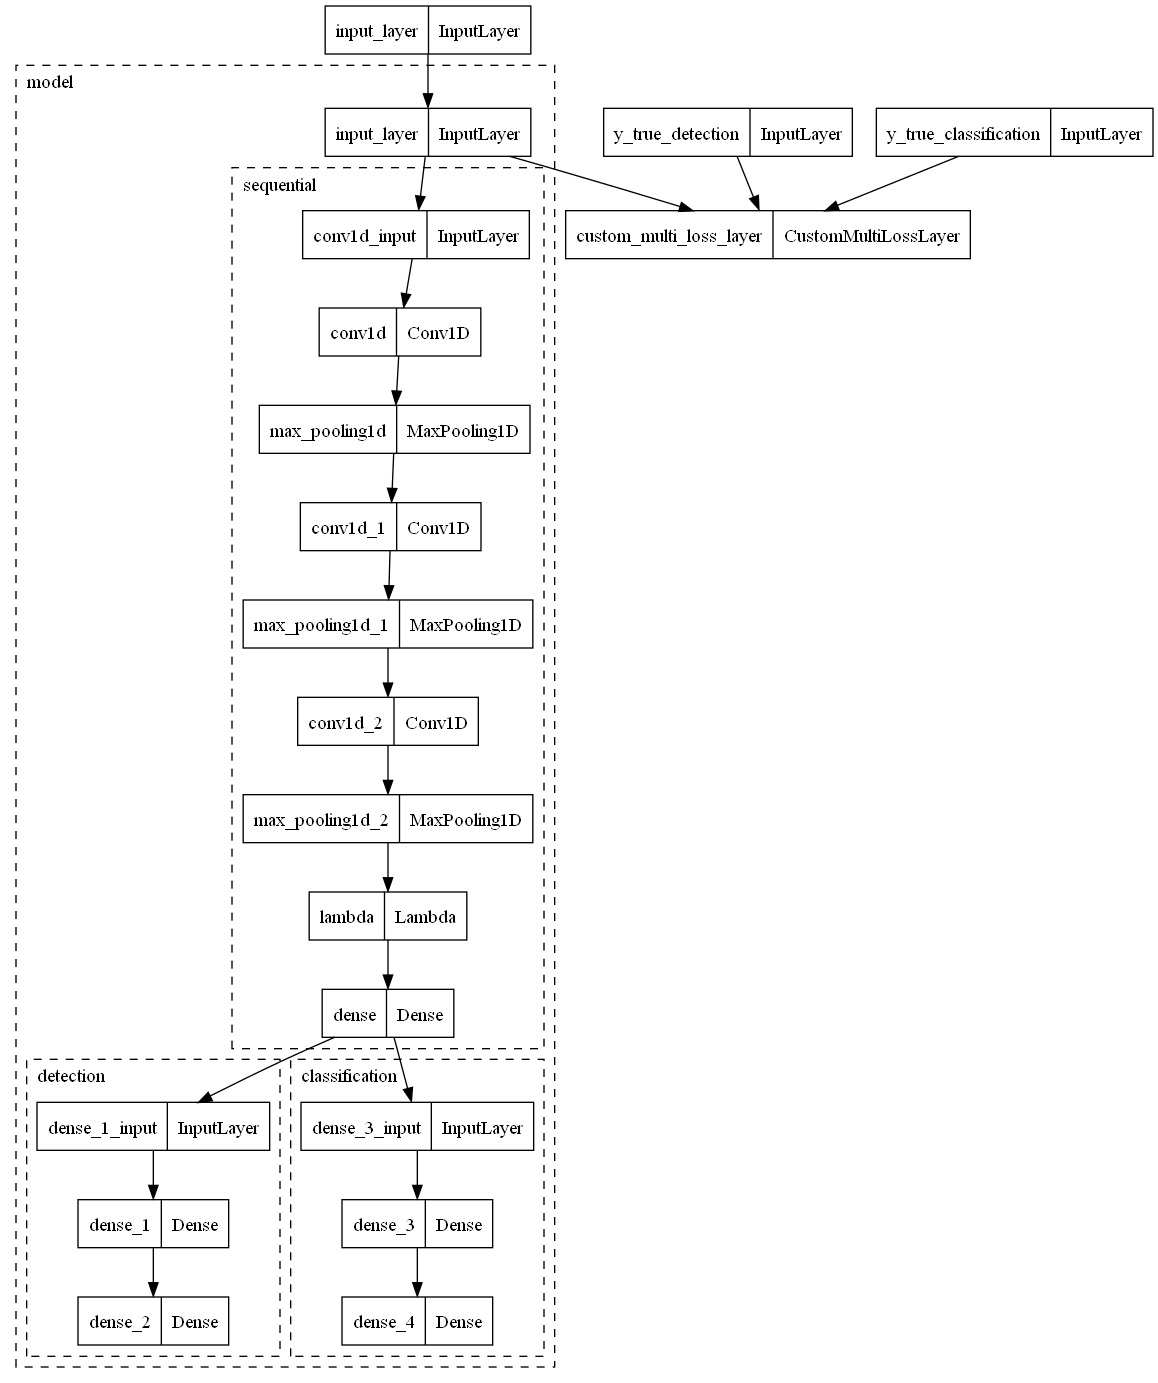

In [12]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
tf.keras.utils.plot_model(trainable_model, expand_nested=True)

In [13]:
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.0001, verbose=1)
early_stopping = EarlyStopping(verbose=1, patience=8)

history = trainable_model.fit(
    x=[x_train, y_d_train, y_c_train],
    y=[y_d_train, y_c_train],
    epochs=epochs,
    batch_size=batch_size,
    validation_data=([x_val, y_d_val, y_c_val], [y_d_val, y_c_val]),
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/100
30/30 [==============================] - 2s 46ms/step - loss: 112.3131 - val_loss: 103.1283 - lr: 0.0010
Epoch 2/100
30/30 [==============================] - 1s 40ms/step - loss: 110.3286 - val_loss: 102.6567 - lr: 0.0010
Epoch 3/100
30/30 [==============================] - 1s 39ms/step - loss: 109.6002 - val_loss: 101.9338 - lr: 0.0010
Epoch 4/100
30/30 [==============================] - 1s 39ms/step - loss: 109.0394 - val_loss: 101.3572 - lr: 0.0010
Epoch 5/100
30/30 [==============================] - 1s 39ms/step - loss: 108.5407 - val_loss: 101.1193 - lr: 0.0010
Epoch 6/100
30/30 [==============================] - 1s 39ms/step - loss: 108.1909 - val_loss: 100.5188 - lr: 0.0010
Epoch 7/100
30/30 [==============================] - 1s 40ms/step - loss: 107.6813 - val_loss: 100.1691 - lr: 0.0010
Epoch 8/100
30/30 [==============================] - 1s 40ms/step - loss: 107.3993 - val_loss: 99.9396 - lr: 0.0010
Epoch 9/100
30/30 [==============================] - 1s 40ms/step

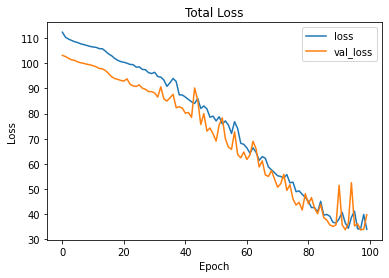

In [14]:
metrics = history.history
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [15]:
test_features = np.array(test_dataset[0])
y_pred = np.zeros(len(test_features))
predictions = trainable_model.predict([test_features, y_pred, y_pred], verbose=1)

y_pred = np.rint(predictions[0])
y_true = y_d_test

test_acc = accuracy_score(y_true, y_pred) * 100
print(f'Detection test set accuracy: {test_acc:.2f}%')

false_alarm_prob = false_alarm_rate(y_true, y_pred)
print(f'Detection test set false alarm prob: {false_alarm_prob}%')

miss_detection_prob = miss_detection_rate(y_true, y_pred)
print(f'Detection test set miss detection prob: {miss_detection_prob}%')

19/19 [==============================] - 0s 7ms/step
Detection test set accuracy: 57.33%
Detection test set false alarm prob: 1.08%
Detection test set miss detection prob: 61.35%


Classification test set accuracy: 45%


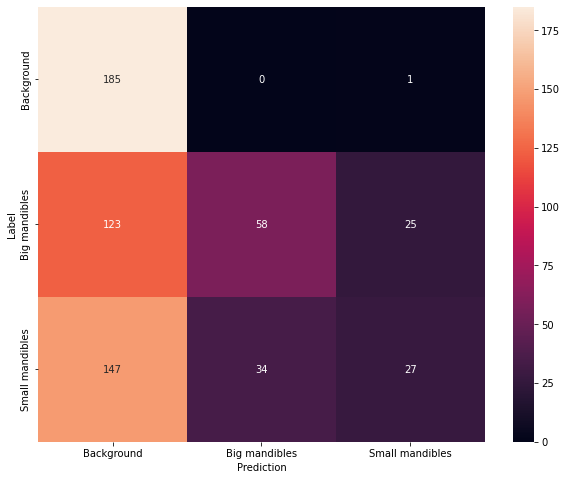

In [16]:
y_pred = np.argmax(predictions[1], axis=1)
y_true = y_c_test

test_acc = accuracy_score(y_true=y_true, y_pred=y_pred)
print(f'Classification test set accuracy: {test_acc:.0%}')
plot_confusion_matrix(list(class_dict.keys()), y_true, y_pred)